# 中国大陆地区的读者请注意！！！
# 同第一章一样
# 本章也换成Tushare来获取数据

In [1]:
#导入必要的库
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#指定下载股票的日期范围
start_date = '2020-01-01'
end_date = '2020-03-20'
#使用ts获取数据
#将时间范围作为参数传入
zgpa = ts.get_k_data('601318',
                    start_date, end_date)
zgpa = zgpa.set_index('date')
#检查是否下载成功
zgpa.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,open,close,high,low,volume,code
date,,,,,,
2020-01-02,81.54,81.76,82.43,81.52,778252.0,601318
2020-01-03,82.45,81.84,82.52,81.54,594980.0,601318
2020-01-06,81.56,81.24,82.51,81.14,636448.0,601318
2020-01-07,81.65,81.79,82.10,81.31,452188.0,601318
2020-01-08,81.62,80.64,81.62,80.14,628053.0,601318


In [4]:
#下面我们来创建交易信号
#为了不影响原始数据，这里创建一个新的数据表
#只保留原始数据中的日期index
zgpa_signal = pd.DataFrame(index = zgpa.index)
#为了更能体现股票的真实价值
#使用Adj Close调整价格作为股票价格
zgpa_signal['price'] = zgpa['close']
#增加一个字段，来存储股价的变化
zgpa_signal['diff'] = zgpa_signal['price'].diff()
#增加diff字段后，第一行会出现空值，我们使用0来进行填补
zgpa_signal = zgpa_signal.fillna(0.0)
#如果股价上涨或不变，则标记为0
#如果股价下跌，则标记为1
zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >= 0, 0,1)
#接下来，根据交易信号的变化进行下单
#一般情况下，在A股市场，买入或卖出至少为100股，即1手
zgpa_signal['order'] = zgpa_signal['signal'].diff()*100
#检查一下下单的情况
zgpa_signal.head()

,price,diff,signal,order
date,,,,
2020-01-02,81.76,0.00,0,NaN
2020-01-03,81.84,0.08,0,0.0
2020-01-06,81.24,-0.60,1,100.0
2020-01-07,81.79,0.55,0,-100.0
2020-01-08,80.64,-1.15,1,100.0


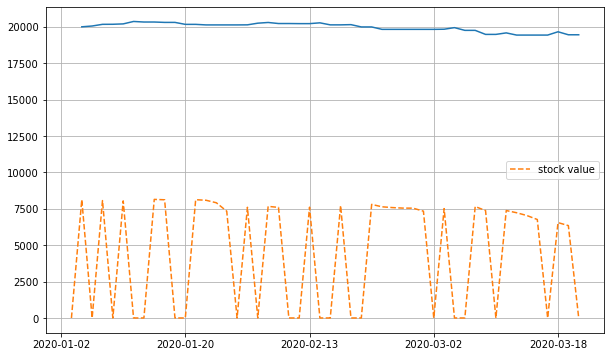

In [8]:
#考虑到股价较高，我们初始给小瓦2万块钱让她去交易
initial_cash = 20000.00
#增加一个字段，代表小瓦交易的股票的市值
zgpa_signal['stock'] = zgpa_signal['order']*zgpa_signal['price']
#两次买卖的订单变化之差就是某一时刻小瓦仓位的变化情况
#持仓股票的数量变化乘以现价，就是代表小瓦交易产生的现金流
#用初始资金减去现金流变化的累加，就是小瓦剩余的现金
zgpa_signal['cash'] = initial_cash -\
(zgpa_signal['order'].diff()*zgpa_signal['price']).cumsum()
#而最股票的市值加上剩余的现金，就是小瓦的总资产
zgpa_signal['total'] = zgpa_signal['stock'] + zgpa_signal['cash']
#为了让小瓦直观看到自己的总资产变化
#我们用图形来进行展示
#设置图形的尺寸是10*6
plt.figure(figsize=(10,6))
#分别绘制总资产和持仓股票市值的变化
plt.plot(zgpa_signal['total'])
plt.plot(zgpa_signal['order'].cumsum()*zgpa_signal['price'],'--',
        label='stock value')
#增加网格，调整一下图注的位置，就可以显示图像了
plt.xticks([0,12,24,36,48])
plt.grid()
plt.legend(loc='center right')
plt.show()

<font size=5 face="黑体">以下是移动平均策略</font>

In [10]:
#这里使用10日均线
period = 10
#设置一个空列表，用来存储每10天的价格
avg_10 = []
#再设置一个空列表，用来存储每10天价格的均值
avg_value = []
#设置一个循环
for price in zgpa['close']:
    #把每天的价格传入到avg_10列表
    avg_10.append(price)
    #当列表中存储的数值多于10个时
    if len(avg_10) > period:
        #就把前面传入的价格数据删掉，确保列表中只有10天的数据
        del avg_10[0]
    #将10天数据的均值传入到avg_value列表中
    avg_value.append(np.mean(avg_10))
#把计算好的10日均价写到股票价格数据表中
zgpa = zgpa.assign(avg_10 = pd.Series(avg_value, index = zgpa.index))
#检查一下是否添加成功
zgpa.head()

,open,close,high,low,volume,code,avg_10
date,,,,,,,
2020-01-02,81.54,81.76,82.43,81.52,778252.0,601318,81.760000
2020-01-03,82.45,81.84,82.52,81.54,594980.0,601318,81.800000
2020-01-06,81.56,81.24,82.51,81.14,636448.0,601318,81.613333
2020-01-07,81.65,81.79,82.10,81.31,452188.0,601318,81.657500
2020-01-08,81.62,80.64,81.62,80.14,628053.0,601318,81.454000


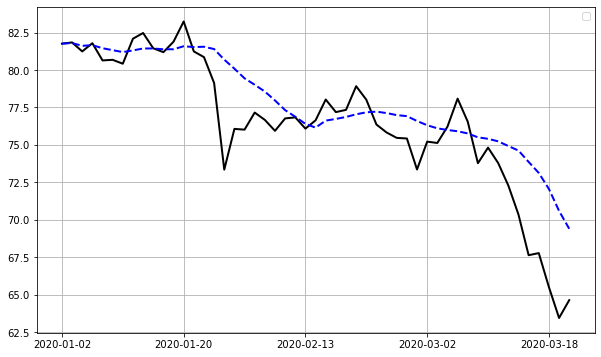

In [12]:
#设置图像尺寸为10*6
plt.figure(figsize=(10,6))
#绘制股价的变化
plt.plot(zgpa['close'],lw=2, c='k')
#绘制10日均线
plt.plot(zgpa['avg_10'], '--',lw=2, c='b')
#添加图注和网格
plt.legend()
plt.grid()
plt.xticks([0,12,24,36,48])
#将图像进行显示
plt.show()

In [13]:
#新建一个数据表，命名为strategy（策略）
#序号保持和原始数据一致
strategy = pd.DataFrame(index = zgpa.index)
#添加一个signal字段，用来存储交易信号
strategy['signal'] = 0
#将5日均价保存到avg_5这个字段
strategy['avg_5'] = zgpa['close'].rolling(5).mean()
#同样，将10日均价保存到avg_10
strategy['avg_10'] = zgpa['close'].rolling(10).mean()
#当5日均价大于10日均价时，标记为1
#反之标记为0
strategy['signal'] = np.where(strategy['avg_5']>strategy['avg_10'], 1,0)
#根据交易信号的变化下单，当交易信号从0变成1时买入
#交易信号从1变成0时卖出
#交易信号不变时不下单
strategy['order'] = strategy['signal'].diff()
#查看数据表后10行
strategy.tail(10)

,signal,avg_5,avg_10,order
date,,,,
2020-03-09,1,75.954,75.508,0.0
2020-03-10,1,75.892,75.407,0.0
2020-03-11,1,75.406,75.239,0.0
2020-03-12,0,74.246,74.925,-1.0
2020-03-13,0,73.006,74.624,0.0
2020-03-16,0,71.778,73.866,0.0
2020-03-17,0,70.370,73.131,0.0
2020-03-18,0,68.714,72.060,0.0
2020-03-19,0,66.946,70.596,0.0


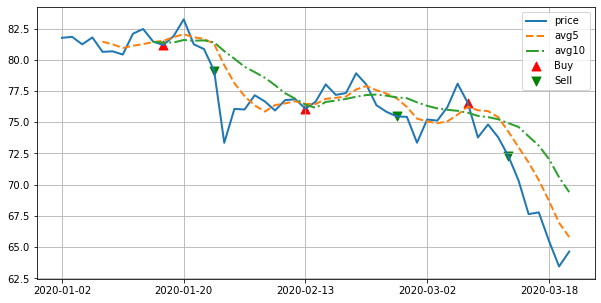

In [14]:
#创建尺寸为10*5的画布
plt.figure(figsize=(10,5))
#使用实线绘制股价
plt.plot(zgpa['close'],lw=2,label='price')
#使用虚线绘制5日均线
plt.plot(strategy['avg_5'],lw=2,ls='--',label='avg5')
#使用-.风格绘制10日均线
plt.plot(strategy['avg_10'],lw=2,ls='-.',label='avg10')
#将买入信号用正三角进行标示
plt.scatter(strategy.loc[strategy.order==1].index,
           zgpa['close'][strategy.order==1],
           marker = '^', s=80,color='r',label='Buy')
#将卖出信号用倒三角进行标示
plt.scatter(strategy.loc[strategy.order==-1].index,
           zgpa['close'][strategy.order==-1],
           marker = 'v', s=80,color='g',label='Sell')
#添加图注
plt.legend()
plt.xticks([0,12,24,36,48])
#添加网格以便于观察
plt.grid()
#显示图像
plt.show()

In [17]:
#这次我们还是给小瓦2万块钱的启动资金
initial_cash = 20000
#新建一个数据表positions，序号保持和strategy数据表一致
#用0将空值进行替换
positions = pd.DataFrame(index = strategy.index).fillna(0)
#因为A股买卖都是最低100股
#因此设置stock字段为交易信号的100倍
positions['stock'] = strategy['signal'] * 100
#创建投资组合数据表，用持仓的股票数量乘股价得出持仓的股票市值
portfolio = pd.DataFrame(index = strategy.index)
portfolio['stock value'] = positions.multiply(zgpa['close'], axis=0)
#同样仓位的变化就是下单的数量
order = positions.diff()
#用初始资金减去下单金额的总和就是剩余的资金
portfolio['cash'] = initial_cash - order.multiply(zgpa['close'],
                                                 axis=0).cumsum()
#剩余的资金+持仓股票市值即为总资产
portfolio['total'] = portfolio['cash'] + portfolio['stock value']
#检查一下后10行
portfolio.tail(10)

,stock value,cash,total
date,,,
2020-03-09,7378.0,12077.0,19455.0
2020-03-10,7482.0,12077.0,19559.0
2020-03-11,7379.0,12077.0,19456.0
2020-03-12,0.0,19306.0,19306.0
2020-03-13,0.0,19306.0,19306.0
2020-03-16,0.0,19306.0,19306.0
2020-03-17,0.0,19306.0,19306.0
2020-03-18,0.0,19306.0,19306.0
2020-03-19,0.0,19306.0,19306.0


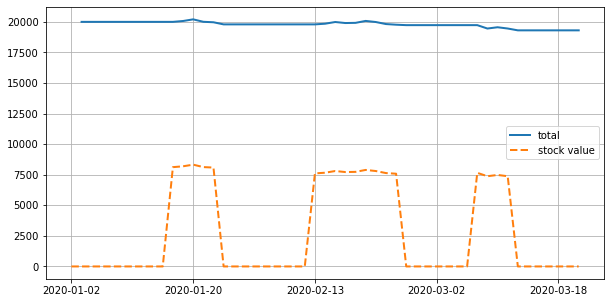

In [19]:
#创建10*5的画布
plt.figure(figsize=(10,5))
#绘制总资产曲线
plt.plot(portfolio['total'], lw=2, label='total')
#绘制持仓股票市值曲线
plt.plot(portfolio['stock value'],lw=2,ls='--', label='stock value')
#添加图注
plt.legend()
#添加网格
plt.grid()
plt.xticks([0,12,24,36,48])
#展示图像
plt.show()

<font size=5 face='黑体'>以下是海龟策略</font>

In [20]:
#创建一个名为turtle的数据表，使用原始数据表的日期序号
turtle = pd.DataFrame(index = zgpa.index)
#设置唐奇安通道的上沿为前5天股价的最高点
turtle['high'] = zgpa['close'].shift(1).rolling(5).max()
#设置唐奇安通道的下沿为过去5天的最低点
turtle['low'] = zgpa['close'].shift(1).rolling(5).min()
#当股价突破上沿时，发出买入信号
turtle['buy'] = zgpa['close'] > turtle['high']
#当股价突破下沿时，发出卖出信号
turtle['sell'] = zgpa['close'] < turtle['low']
#检查信号创建情况
turtle.tail()

,high,low,buy,sell
date,,,,
2020-03-16,74.82,70.35,False,True
2020-03-17,74.82,67.64,False,False
2020-03-18,73.79,67.64,False,True
2020-03-19,72.29,65.51,False,True
2020-03-20,70.35,63.45,False,False


In [21]:
#初始的订单状态为0
turtle['orders']=0
#初始的仓位为0
position = 0
#设置循环，遍历turtle数据表
for k in range(len(turtle)):
    #当买入信号为True且仓位为0时下单买入1手
    if turtle.buy[k] and position ==0:
        #修改对应的orders值为1
        turtle.orders.values[k] = 1
        #仓位也增加1手
        position = 1
    #而当卖出信号为True且有持仓时买出1手
    elif turtle.sell[k] and position > 0:
        #orders的值修改为-1
        turtle.orders.values[k] = -1
        #仓位相应清零
        position = 0   
#检查是否成功
turtle.tail(15)

,high,low,buy,sell,orders
date,,,,,
2020-03-02,76.36,73.36,False,False,0
2020-03-03,75.83,73.36,False,False,0
2020-03-04,75.47,73.36,True,False,1
2020-03-05,76.22,73.36,True,False,0
2020-03-06,78.09,73.36,False,False,0
2020-03-09,78.09,75.13,False,True,-1
2020-03-10,78.09,73.78,False,False,0
2020-03-11,78.09,73.78,False,False,0
2020-03-12,78.09,73.78,False,True,0


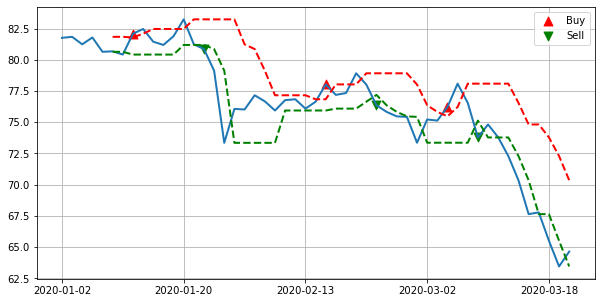

In [24]:
#创建10*5的画布
plt.figure(figsize=(10,5))
#绘制股价的折线图
plt.plot(zgpa['close'],lw=2)
#绘制唐奇安通道上沿
plt.plot(turtle['high'],lw=2, ls='--',c='r')
#绘制唐奇安通道下沿
plt.plot(turtle['low'],lw=2,ls='--',c='g')
#标出买入订单，用正三角标记
plt.scatter(turtle.loc[turtle.orders==1].index,
           zgpa['close'][turtle.orders==1],
           marker='^',s=80,color='r',label='Buy')
#标出卖出订单，用倒三角标记
plt.scatter(turtle.loc[turtle.orders==-1].index,
           zgpa['close'][turtle.orders==-1],
           marker='v',s=80,color='g',label='Sell')
#添加网格、图注并显示
plt.legend()
plt.xticks([0,12,24,36,48])
plt.grid()
plt.show()

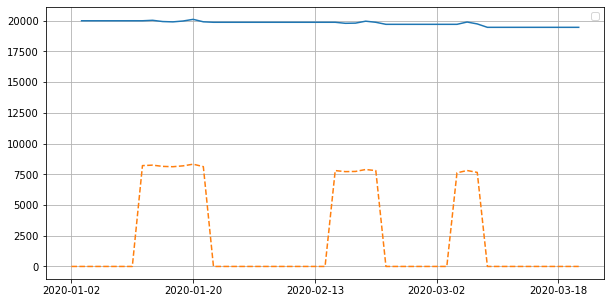

In [26]:
#再次给小瓦2万块初始资金
initial_cash = 20000
#创建新的数据表，序号和turtle数据表一致
positions = pd.DataFrame(index=turtle.index).fillna(0.0)
#每次交易为1手，即100股，仓位即买单和卖单的累积加和
positions['stock'] = 100 * turtle['orders'].cumsum()
#创建投资组合数据表
portfolio = positions.multiply(zgpa['close'], axis=0)
#持仓市值为持仓股票数乘以股价
portfolio['holding_values'] = (positions.multiply(zgpa['close'], axis=0))
#计算出仓位的变化
pos_diff = positions.diff()
#剩余的现金是初始资金减去仓位变化产生的现金流累计加和
portfolio['cash'] = initial_cash - (pos_diff.multiply(zgpa['close'], axis=0)).cumsum()
#总资产即为持仓股票市值加剩余现金
portfolio['total'] = portfolio['cash'] + portfolio['holding_values']
#使用可视化的方式展示
#下面的代码都很熟悉了，就不逐行注释了
plt.figure(figsize=(10,5))
plt.plot(portfolio['total'])
plt.plot(portfolio['holding_values'],'--')
plt.grid()
plt.legend()
plt.xticks([0,12,24,36,48])
plt.show()

In [27]:
#检查最后若干天小瓦的资产情况
portfolio.tail(13)

,stock,holding_values,cash,total
date,,,,
2020-03-04,7622.0,7622.0,12088.0,19710.0
2020-03-05,7809.0,7809.0,12088.0,19897.0
2020-03-06,7655.0,7655.0,12088.0,19743.0
2020-03-09,0.0,0.0,19466.0,19466.0
2020-03-10,0.0,0.0,19466.0,19466.0
2020-03-11,0.0,0.0,19466.0,19466.0
2020-03-12,0.0,0.0,19466.0,19466.0
2020-03-13,0.0,0.0,19466.0,19466.0
2020-03-16,0.0,0.0,19466.0,19466.0
